# CS-VQE experimental results for a single-cell Kagome lattice with an open boundary

Code to reproduce the experimental results in the follow work:
> Weaving, T., Ralli, A., Wimalaweera, V., Love, P. J., & Coveney, P. V. (2025). Simulating the Antiferromagnetic Heisenberg Model on a Spin-Frustrated Kagome Lattice with the Contextual Subspace Variational Quantum Eigensolver. arXiv preprint arXiv:2506.12391.

Note statistical bootstrapping is applied, so results may vary slightly between runs.

In [1]:
from symmer import PauliwordOp
from qiskit_ibm_runtime import RuntimeDecoder
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=UserWarning)
from matplotlib import pyplot as plt

H_cs = {
    "IIIII":-1.000+0.000j,
    "IIIZZ":1.000+0.000j,
    "IIZZI":1.000+0.000j,
    "IZIII":1.000+0.000j,
    "IZZII":1.000+0.000j,
    "ZIIII":7.000+0.000j,
    "ZIIZZ":1.000-0.000j,
    "ZIZZI":1.000-0.000j,
    "ZZIII":1.000+0.000j,
    "ZZZII":1.000-0.000j,
    "IIIIX":1.000-0.000j,
    "ZIIIX":-1.000+0.000j,
    "IIIXI":-1.000+0.000j,
    "ZIIXI":1.000+0.000j,
    "IIXII":-1.000+0.000j,
    "ZIXII":1.000+0.000j,
    "IXIII":-1.000+0.000j,
    "ZXIII":1.000+0.000j,
    "IXXXX":1.000-0.000j,
    "ZXXXX":-1.000+0.000j
}
H_cs = PauliwordOp.from_dictionary(H_cs)

cliques = H_cs.clique_cover(edge_relation='QWC')

/opt/miniconda3/envs/kagome_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-05 17:37:34,391	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
best_CG_runs = ['job_id_8192_CG_1', 'job_id_4096_CG_2', 'job_id_256_1']
best_BFGS_runs = ['job_id_8192_BFGS_1', 'job_id_4096_BFGS_2', 'job_id_1024_BFGS_4']

with open(f'data/ibmq_guadalupe_vqe_results_{best_CG_runs[0]}.txt', 'r') as f:
    dec = RuntimeDecoder()
    data_in = dec.decode(f.read())
    vqe_result = data_in['result']
    vqe_inputs = data_in['inputs']

In [3]:
# ! pip install statsmodels

In [4]:
from postprocessing import perform_wls_zne

effective_n_shots = vqe_result['circuits']['n_parallel'] * vqe_inputs['n_shots']
(
    ZNE_WLS_energy, ZNE_WLS_stddev, ZNE_WLS_funcs, 
    (ZNE_energy_hist, ZNE_stddev_hist)
) = perform_wls_zne(cliques, vqe_result, effective_n_shots)

ZNE_energy_data = np.hstack([ZNE_WLS_energy.reshape([-1,1]), ZNE_energy_hist])
ZNE_stddev_data = np.hstack([ZNE_WLS_stddev.reshape([-1,1]), ZNE_stddev_hist])

In [5]:
from postprocessing import symmetrize

## Discard experimental results that violate physical symmetries of the Hamiltonian
## In this case only the Z2-symmetry ZIIII, with an assigned eigenvalue of -1:
ZIIII = PauliwordOp.from_list(['ZIIII'])
rectified_results = symmetrize(
    data_in = vqe_result, 
    symmetry = ZIIII, 
    permitted_value = -1
)
effective_n_shots = rectified_results['circuits']['n_parallel'] * vqe_inputs['n_shots']
(
    ZNE_WLS_energy_rectified, ZNE_WLS_stddev_rectified, ZNE_WLS_funcs_rectified, 
    (ZNE_energy_hist_rectified, ZNE_stddev_hist_rectified)
) = perform_wls_zne(cliques, rectified_results, effective_n_shots)

ZNE_energy_data_rectified = np.hstack([ZNE_WLS_energy_rectified.reshape([-1,1]), ZNE_energy_hist_rectified])
ZNE_stddev_data_rectified = np.hstack([ZNE_WLS_stddev_rectified.reshape([-1,1]), ZNE_energy_hist_rectified])

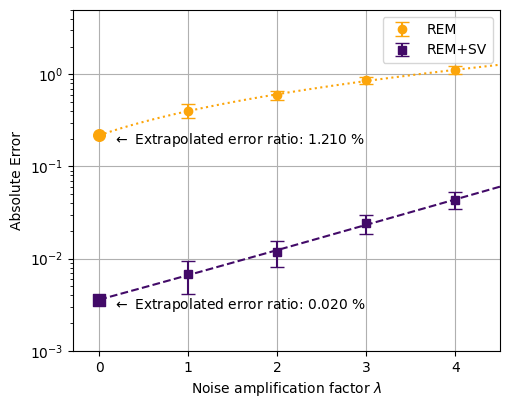

In [6]:
plt.rc('axes', axisbelow=True)

params = list(vqe_result['parameter_history'].values())
conv_data = np.asarray(params) - params[-1]
conv_mask = np.linalg.norm(conv_data, axis=1) < 4e-2

X_grad, Y_grad = zip(*vqe_result['gradient_history']['values'].items())
G_norm = np.linalg.norm(Y_grad, axis=1, ord=1)
conv_inv = np.where(G_norm/min(G_norm)<1.001)[0][0]
conv_inv=15
conv_mask = np.zeros(conv_data.shape[0], dtype=bool)
conv_mask[conv_inv:] = True

nf = [1,2,3,4]
Y = np.mean(ZNE_energy_hist[conv_mask], axis=0)
YERR = np.std(ZNE_energy_hist[conv_mask], axis=0)
Y_SV = np.mean(ZNE_energy_hist_rectified[conv_mask], axis=0)
YERR_SV = np.std(ZNE_energy_hist_rectified[conv_mask], axis=0)

from scipy.optimize import minimize

def get_func(a,b,c):
    return np.vectorize(lambda x:np.exp(a*x+b)+c)
def resid(abc):
    return np.sum(np.square((get_func(*abc)(nf) - Y)/YERR))
def resid_SV(abc):
    return np.sum(np.square((get_func(*abc)(nf) - Y_SV)/YERR_SV))

zne_wls_curve = get_func(*minimize(resid, x0=(1,-1,-18))['x'])
zne_wls_curve_SV = get_func(*minimize(resid_SV, x0=(1,-1,-18))['x'])
error_ratio = abs(100*(zne_wls_curve(0) + 18)/18)
error_ratio_SV = abs(100*(zne_wls_curve_SV(0) + 18)/18)
energy_from_ratio = lambda er:(er/100-1)*18

fig, axis = plt.subplots(figsize=(5,4))
fig.tight_layout()
axis.errorbar(
    x=nf, y=abs(Y+18), yerr=YERR,
    capsize=5, marker='o', ls='', color=plt.cm.inferno(4/5),
    label='REM'
)
axis.text(0.15,abs(zne_wls_curve(0)+18)*0.8,f'$\leftarrow$ Extrapolated error ratio:{error_ratio: .3f} %')
axis.errorbar(
    x=nf, y=abs(Y_SV+18), yerr=YERR_SV,
    capsize=5, marker='s', ls='', color=plt.cm.inferno(1/5),
    label='REM+SV'
)
axis.text(0.15,abs(zne_wls_curve_SV(0)+18)*0.8,f'$\leftarrow$ Extrapolated error ratio:{error_ratio_SV: .3f} %')
X_ = np.linspace(0,5,1000)
axis.plot(X_, abs(zne_wls_curve(X_)+18), color=plt.cm.inferno(4/5), ls=':')
axis.plot(X_, abs(zne_wls_curve_SV(X_)+18), color=plt.cm.inferno(1/5), ls='--')
axis.scatter([0],[abs(zne_wls_curve(0)+18)],color=plt.cm.inferno(4/5), marker='o', s=70)
axis.scatter([0],[abs(zne_wls_curve_SV(0)+18)],color=plt.cm.inferno(1/5), marker='s', s=70)
axis.set_xticks([0]+nf)
axis.set_yscale('log')
axis.grid()
axis.set_ylim([1e-3,5])
axis.set_xlim([-0.3,4.5])
axis.set_xlabel('Noise amplification factor $\lambda$')
axis.set_ylabel('Absolute Error')
axis.legend()
fig.savefig('plots/final_weighted_ZNE_estimate.png', dpi=300, bbox_inches='tight')

/var/folders/1m/bkmrx8hs2kd616wt3k68n4zm0000gn/T/ipykernel_48975/1487624569.py:23: RuntimeWarning: overflow encountered in exp
  return np.vectorize(lambda x:np.exp(a*x+b)+c)
/opt/miniconda3/envs/kagome_env/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/var/folders/1m/bkmrx8hs2kd616wt3k68n4zm0000gn/T/ipykernel_48975/1487624569.py:23: RuntimeWarning: overflow encountered in exp
  return np.vectorize(lambda x:np.exp(a*x+b)+c)
/var/folders/1m/bkmrx8hs2kd616wt3k68n4zm0000gn/T/ipykernel_48975/3158245268.py:33: RuntimeWarning: overflow encountered in square
  return np.sum(np.square((get_func(*abc)(nf) - ZNE_energy_data_rectified[i,1:])/1))


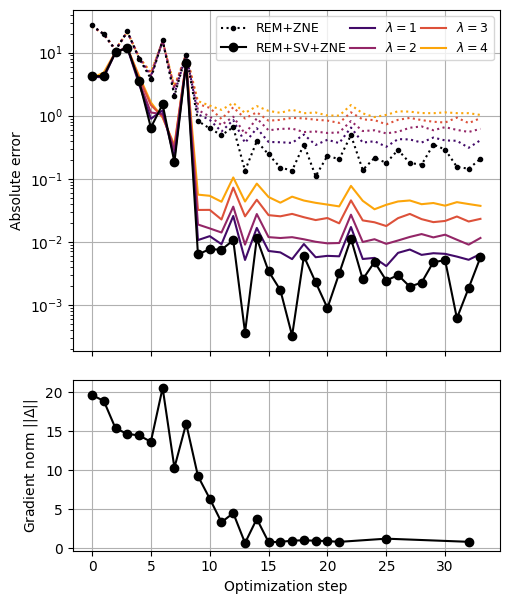

In [7]:

params = list(vqe_result['parameter_history'].values())
X_grad, Y_grad = zip(*vqe_result['gradient_history']['values'].items())

energy_from_ratio = lambda er:(er/100-1)*18

Y1=ZNE_WLS_energy
Y2=ZNE_WLS_energy_rectified
Y1_stddev=ZNE_WLS_stddev
Y2_stddev=ZNE_WLS_stddev_rectified

params = list(vqe_result['parameter_history'].values())
X_grad, Y_grad = zip(*vqe_result['gradient_history']['values'].items())

X_grad=X_grad
Y_grad=np.asarray(Y_grad)

fig, axes = plt.subplots(2,1,figsize=(5,6),gridspec_kw={'height_ratios':(2,1)},sharex=True)
fig.tight_layout()

X = np.arange(len(vqe_result['energy_history']['values']))
X = [int(x) for x in X]

Y1_abs = []
Y2_abs = []

for i in range(ZNE_energy_data.shape[0]):
    def resid(abc):
        return np.sum(np.square((get_func(*abc)(nf) - ZNE_energy_data[i,1:])/1))
    zne_wls_curve = get_func(*minimize(resid, x0=(1,-1,-18))['x'])
    Y1_abs.append(abs(zne_wls_curve(0)+18))
for i in range(ZNE_energy_data_rectified.shape[0]):
    def resid_SV(abc):
        return np.sum(np.square((get_func(*abc)(nf) - ZNE_energy_data_rectified[i,1:])/1))
    zne_wls_curve_rectified = get_func(*minimize(resid_SV, x0=(1,-1,-18))['x'])
    Y2_abs.append(abs(zne_wls_curve_rectified(0)+18))

axes[0].plot(X, Y1_abs, color=plt.cm.inferno(0), label='REM+ZNE', marker='.', ls=':', zorder=10)
axes[0].plot(X, Y2_abs, color='black', label='REM+SV+ZNE', marker='o', ls='-', zorder=10)

for i in range(1,5):
    color = plt.cm.inferno((i)/5)
    nrg=abs(ZNE_energy_data.T[i]+18)
    std=ZNE_stddev_data.T[i]
    axes[0].plot(X, nrg, color=color, ls=':', marker='', zorder=10-i)
    nrg=abs(ZNE_energy_data_rectified.T[i]+18)
    axes[0].plot(X, nrg, label=f'$\lambda={i}$', color=color, ls='-', marker='', zorder=10-i)

axis_grad = axes[1]
X_grad = [int(x) for x in X_grad]
axis_grad.plot(
    X_grad, 
    np.linalg.norm(Y_grad, axis=1, ord=1), 
    color='black', 
    label='Norm of parameter gradient',
    marker='o'
)
axis_grad.set_ylabel('Gradient norm $||\\Delta||$')

axes[0].grid()
axes[1].grid()

axes[0].set_ylabel('Absolute error')
axes[1].set_xlabel('Optimization step')
axes[0].set_yscale('log')
axes[0].legend(ncol=3, fontsize=9, loc='upper right', columnspacing=0.3)
fig.savefig('plots/final_VQE_simulation.png', dpi=300, bbox_inches='tight')